**Section 3 - Unsupervised learning - clustering**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pickle

with open('/content/drive/My Drive/ML_project/shared_data.pkl', 'rb') as file:
  data = pickle.load(file)

data.head()

,session_id,full_session,first_timestamp,Set_Fingerprint,date_column,num_characters,Word_Count,num_intents,tf_idf
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,1559641511,"[Defense Evasion, Discovery]",2019-06-04,280,62,2,"[0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,..."
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,1559641550,"[Defense Evasion, Discovery]",2019-06-04,280,62,2,"[0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,..."
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,1559642081,"[Defense Evasion, Discovery]",2019-06-04,280,62,2,"[0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,..."
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,1559643734,"[Defense Evasion, Discovery]",2019-06-04,280,62,2,"[0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,..."
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,1559644639,"[Defense Evasion, Discovery]",2019-06-04,280,62,2,"[0.0, 0.0, 0.0, 0.0, 0.12857118194428388, 0.0,..."


In [4]:
## Importing all necessary libraries

import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import matplotlib.font_manager as fm
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter


Two algorithms are used for this section:

1.   K-Means
2.   GMM (Gaussian Mixture Model)

### **K-Means Algorithm**

**1. Determine the number of clusters: This can be done using methods like the elbow method or silhouette analysis. Explain your reasoning.**



In [5]:
# Convert lists to arrays

X = np.array([np.array(row) for row in data['tf_idf']])

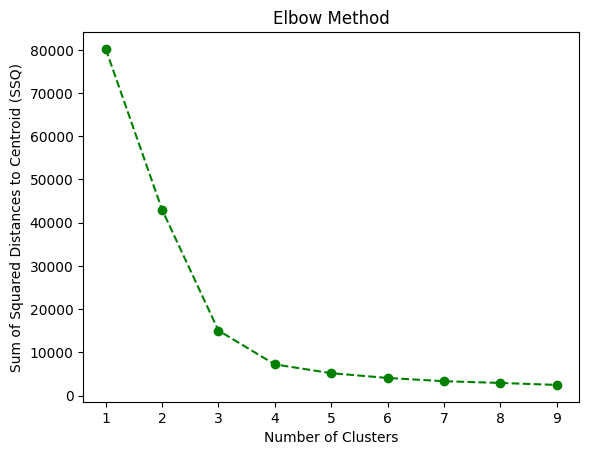

In [ ]:
## Elbow Method - K-Means

ssq = []

# KMeans with different numbers of clusters and compute SSQ
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    ssq.append(kmeans.inertia_)

plt.plot(range(1, 10), ssq, 'go--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances to Centroid (SSQ)')
plt.savefig('/content/drive/My Drive/EM1.png')
plt.show()

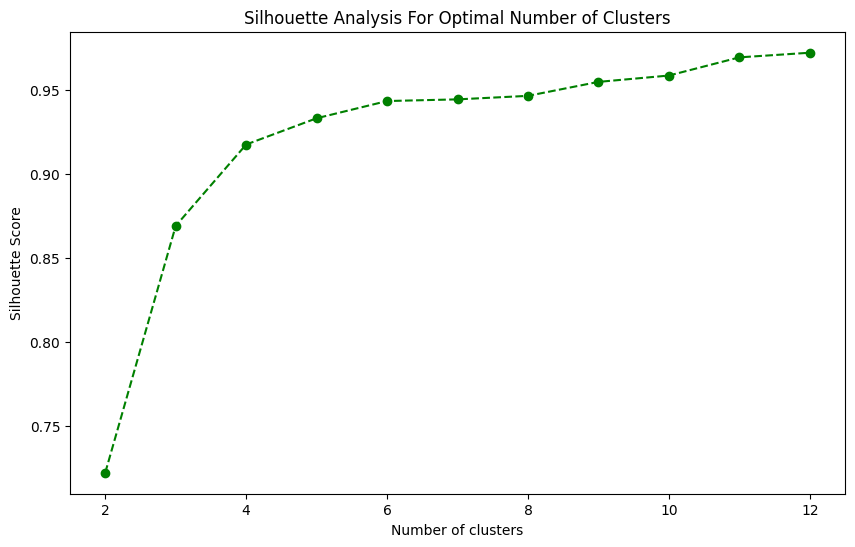

In [ ]:
## Silhouette Analysis - K-Means

#subsample of all the data
sampled_data=data.sample(frac=0.25,random_state=42)
X= np.array([np.array(row) for row in sampled_data['tf_idf']])

silhouette_scores = []
K = range(2, 13)  # Range of number of clusters

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'go--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal Number of Clusters')
plt.savefig('/content/drive/My Drive/SA1.png')
plt.show()

**2. Tune other hyper-parameters, if any.**

In [ ]:
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)

# Function to perform Grid Search for K-Means
def tune_kmeans(X):
    param_grid = {
        'n_clusters': [3, 4, 5],
        'init': ['k-means++', 'random'],
        'n_init': [10, 20, 30]
    }
    kmeans = KMeans(random_state=42)
    grid_search = GridSearchCV(kmeans, param_grid, cv=3, scoring=silhouette_scorer)
    grid_search.fit(X)
    return grid_search.best_params_, grid_search.best_score_

best_params_kmeans, best_score_kmeans = tune_kmeans(X)
print(f"Best K-Means Parameters: {best_params_kmeans}")
print(f"Best K-Means Silhouette Score: {best_score_kmeans}")

KeyboardInterrupt: 

**3. Visualize the clusters through t-SNE visualization.**

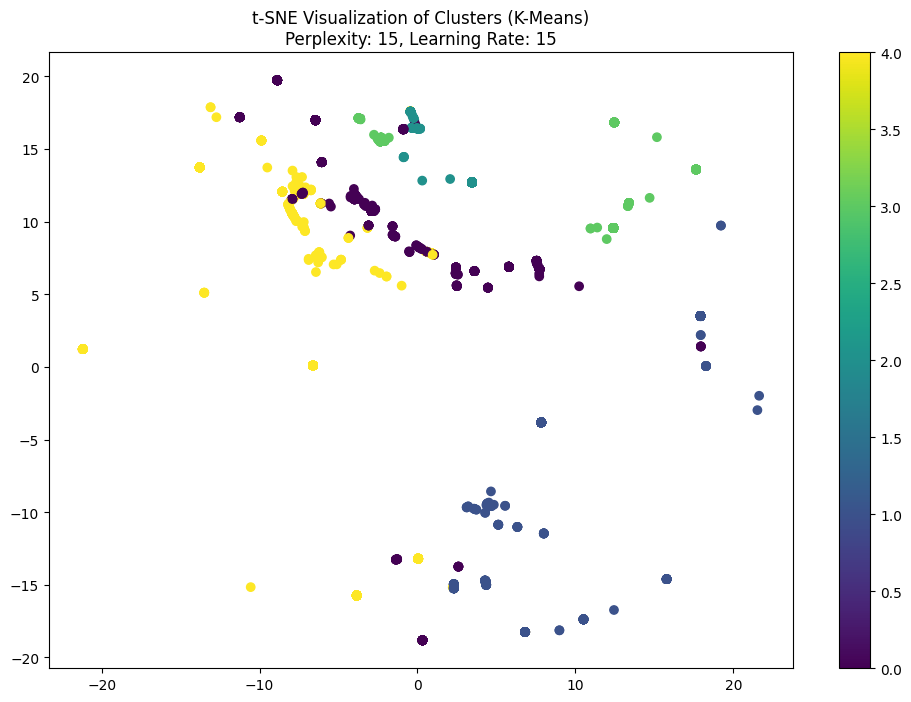

In [ ]:
## t-SNE - K-Means

# PCA for dimensionality reduction
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

perplexities = [15]
learning_rates = [15]
for perplexity in perplexities:
    for learning_rate in learning_rates:
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=1000, random_state=42)
        X_tsne = tsne.fit_transform(X_pca)

        # K-Means with best parameters
        kmeans = KMeans(**best_params_kmeans, random_state=42)
        kmeans.fit(X)
        kmeans_labels = kmeans.labels_

        # Plotting K-Means clusters
        plt.figure(figsize=(12, 8))
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', label='K-Means')
        plt.title(f't-SNE Visualization of Clusters (K-Means)\nPerplexity: {perplexity}, Learning Rate: {learning_rate}')
        plt.colorbar()
        #plt.savefig(f'/content/drive/My Drive/ML_project/TSNE_KMeans_p{perplexity}_lr{learning_rate}.png')
        plt.show()


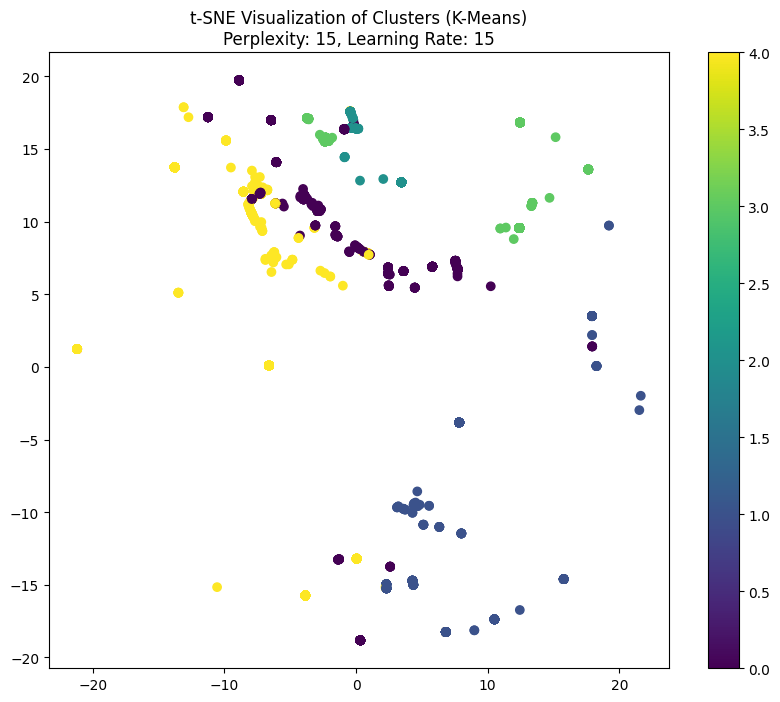

In [ ]:
# Plotting K-Means clusters
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', label='K-Means')
plt.title(f't-SNE Visualization of Clusters (K-Means)\nPerplexity: {perplexity}, Learning Rate: {learning_rate}')
plt.colorbar()
plt.show()

**4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the most representative.**



 **5.Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

In [ ]:
## Word Cloud - K-Means

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['full_session'])

feature_names = tfidf_vectorizer.get_feature_names_out()

#cluster labels
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', random_state=42, n_init=10)
kmeans.fit(X_tfidf)
labels = kmeans.labels_

cluster_words = {i: [] for i in range(optimal_clusters)}

for i, label in enumerate(labels):
    row = X_tfidf.getrow(i).tocoo()
    for j, v in zip(row.col, row.data):
        cluster_words[label].append((feature_names[j], v))

In [ ]:
# top 10 unique tuples for each key
def get_top_10_per_key(input_dict):
    top_10_dict = {}
    for key, value in input_dict.items():
        sorted_tuples = sorted(value, key=lambda x: x[1], reverse=True)
        unique_tuples = []
        seen_words = set()

        for word, score in sorted_tuples:
            if word not in seen_words:
                unique_tuples.append((word, score))
                seen_words.add(word)
            if len(unique_tuples) == 10:
                break

        top_10_dict[key] = unique_tuples
    return top_10_dict

top_10_dict = get_top_10_per_key(cluster_words)

Word cloud for cluster 0 saved to /content/drive/My Drive/wordcloud_KMeans_cluster_0.png


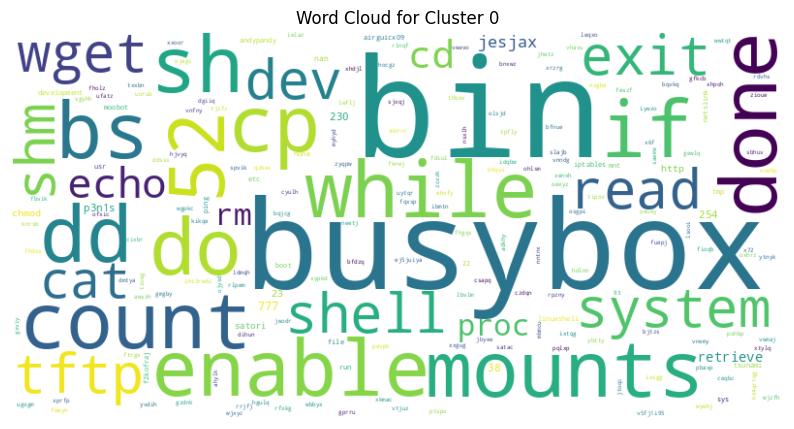

Word cloud for cluster 1 saved to /content/drive/My Drive/wordcloud_KMeans_cluster_1.png


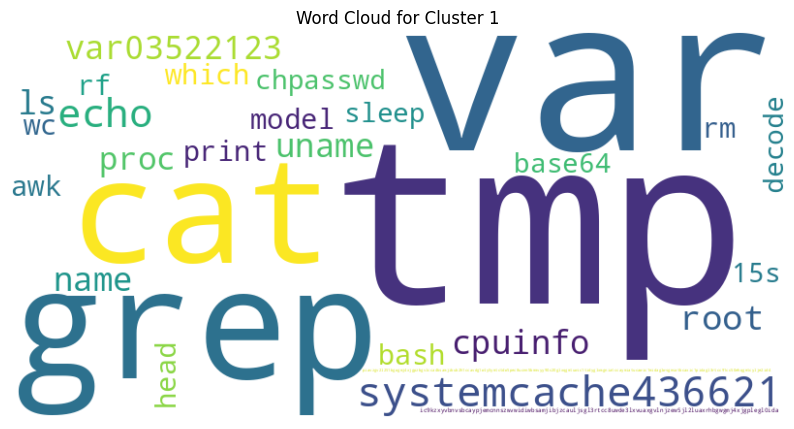

Word cloud for cluster 2 saved to /content/drive/My Drive/wordcloud_KMeans_cluster_2.png


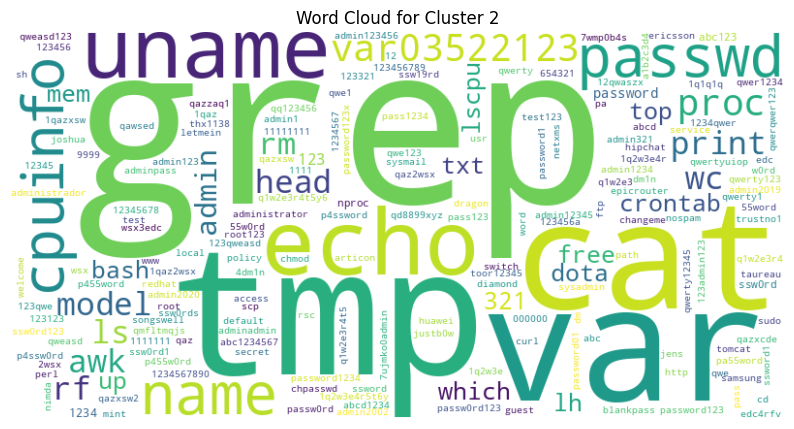

Word cloud for cluster 3 saved to /content/drive/My Drive/wordcloud_KMeans_cluster_3.png


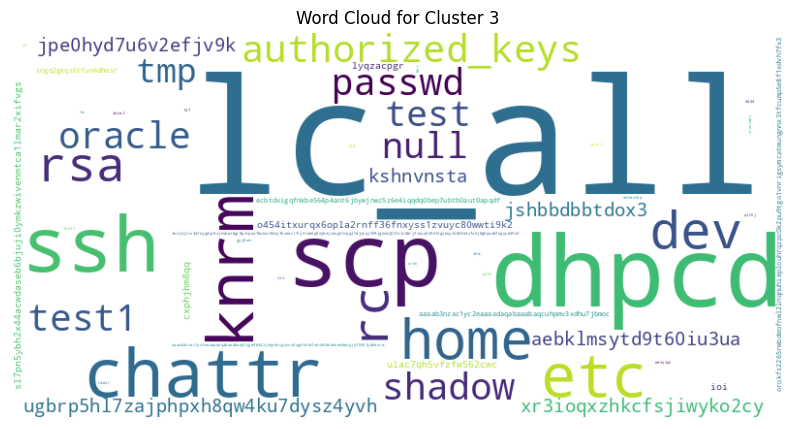

In [ ]:
# generating word clouds for each cluster
def generate_word_cloud(cluster_words):
    for cluster, words in cluster_words.items():
        word_freq = {}
        for word, score in words:
            if word in word_freq:
                word_freq[word] += score
            else:
                word_freq[word] = score

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Cluster {cluster}")
        output_path = f'/content/drive/My Drive/wordcloud_KMeans_cluster_{cluster}.png'
        wordcloud.to_file(output_path)
        print(f"Word cloud for cluster {cluster} saved to {output_path}")

        plt.show()

# Generate word clouds for each cluster
generate_word_cloud(cluster_words)

**6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics). As an example, see the image below, where we perform a similar exercise (through graph community detections).NOTE: you do not have to do this exercise for all the clusters, but only on some examples.**

In [1]:
# Function to display sample sessions from each cluster
def display_sample_sessions(cluster_id, num_samples=5):
    cluster_sessions = data[data.index.isin([i for i, label in enumerate(labels) if label == cluster_id])]
    print(f"Cluster {cluster_id} - Sample Sessions:")
    for session in cluster_sessions.sample(num_samples)['full_session']:
        print(session)
        print("-" * 80)

#sample sessions for each cluster
for cluster_id in range(optimal_clusters):
    display_sample_sessions(cluster_id)


NameError: name 'optimal_clusters' is not defined

Cluster 0: Associated fine-grained categories - Discovery, Execution, Impact
Cluster 1: Associated fine-grained categories - Discovery, Defense Evasion, Impact
Cluster 2: Associated fine-grained categories - Persistence, Privilege Escalation, Lateral Movement
Cluster 3: Associated fine-grained categories - Discovery, Execution, Credential Access


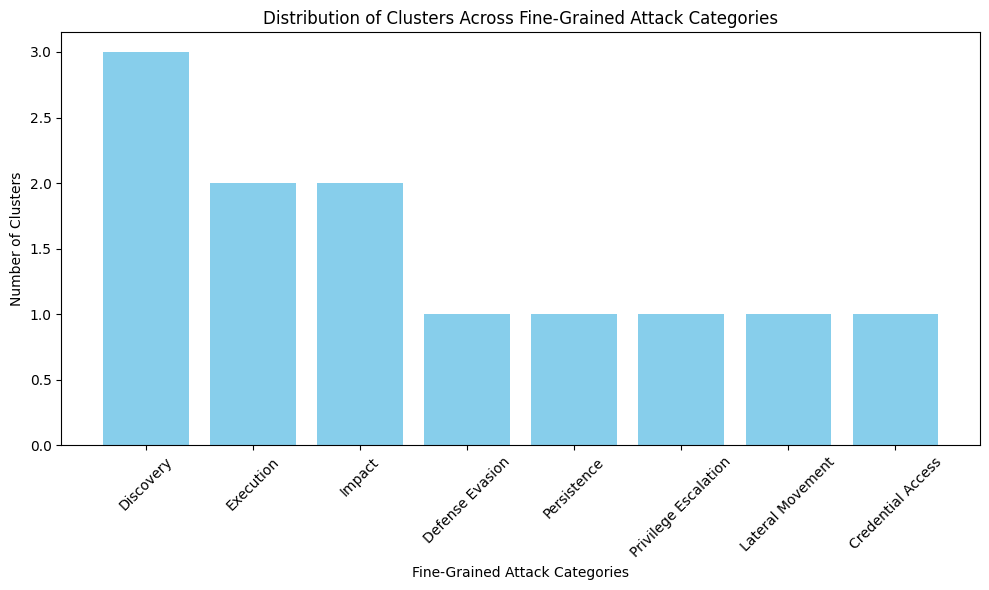

In [ ]:
cluster_fine_grained_categories = {
    0: ['Discovery', 'Execution', 'Impact'],
    1: ['Discovery', 'Defense Evasion', 'Impact'],
    2: ['Persistence', 'Privilege Escalation', 'Lateral Movement'],
    3: ['Discovery', 'Execution', 'Credential Access']
}

# Print clusters and associated fine-grained categories
for cluster_id, categories in cluster_fine_grained_categories.items():
    print(f"Cluster {cluster_id}: Associated fine-grained categories - {', '.join(categories)}")

# Visualize the distribution of fine-grained categories across clusters
category_counts = {}
for categories in cluster_fine_grained_categories.values():
    for category in categories:
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Fine-Grained Attack Categories')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Clusters Across Fine-Grained Attack Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **GMM - Gaussian Mixture Algorithm**

**1. Determine the number of clusters: This can be done using methods like the elbow method or silhouette analysis. Explain your**

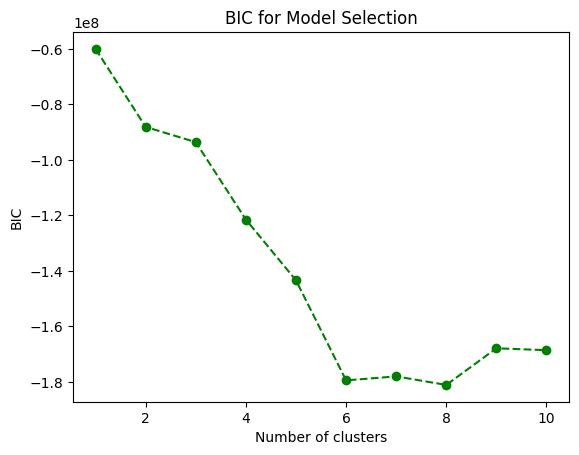

In [ ]:
## Elbow Method - GMM

# Standardize the data

X_tfidf = np.array(data['tf_idf'].tolist())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf)

bic = []
for i in range(1, 11):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(X_scaled)
    bic.append(gmm.bic(X_scaled))

plt.figure()
plt.plot(range(1, 11), bic, 'go--')
plt.title('BIC for Model Selection')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.savefig('/content/drive/My Drive/EM2.png')
plt.show()

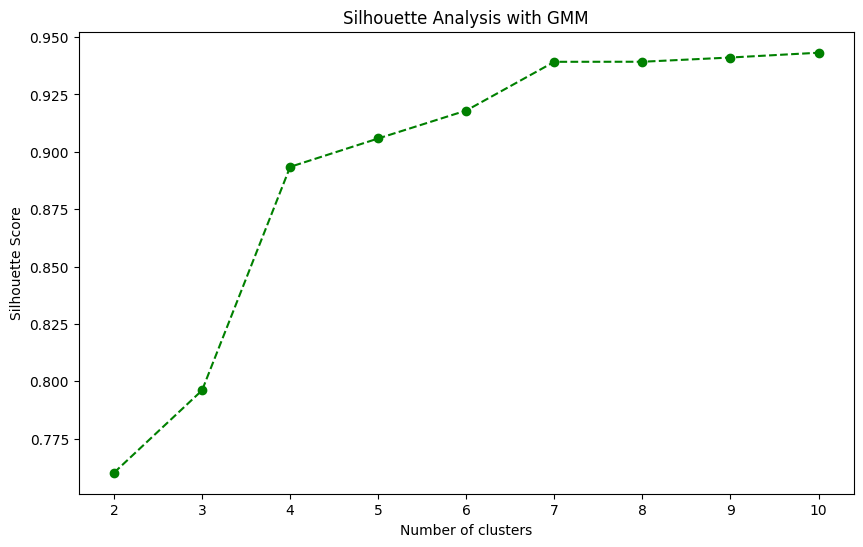

In [ ]:
## Silhouette Analysis - GMM

#subsample of all the data
sampled_data=data.sample(frac=0.25,random_state=42)
X= np.array([np.array(row) for row in sampled_data['tf_idf']])

X_tfidf = np.array(sampled_data['tf_idf'].tolist())

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_tfidf)

silhouette_scores = []
for i in range(2, 11):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))


plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go--')
plt.title('Silhouette Analysis with GMM')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.savefig('/content/drive/My Drive/SA2.png')
plt.show()

**2. Tune other hyper-parameters, if any.**

In [ ]:
def tune_gmm(X):
    param_grid = {
        'n_components': [3, 4, 5, 6],
        'covariance_type': ['full', 'tied', 'diag', 'spherical']
    }
    gmm = GaussianMixture(random_state=42)
    best_score = -np.inf
    best_params = None
    for n_components in param_grid['n_components']:
        for covariance_type in param_grid['covariance_type']:
            gmm.set_params(n_components=n_components, covariance_type=covariance_type)
            labels = gmm.fit_predict(X)
            score = silhouette_score(X, labels)
            if score > best_score:
                best_score = score
                best_params = {'n_components': n_components, 'covariance_type': covariance_type}
    return best_params, best_score


best_params_gmm, best_score_gmm = tune_gmm(X)
print(f"Best GMM Parameters: {best_params_gmm}")
print(f"Best GMM Silhouette Score: {best_score_gmm}")

Best GMM Parameters: {'n_components': 6, 'covariance_type': 'tied'}
Best GMM Silhouette Score: 0.9389735924648545


**3. Visualize the clusters through t-SNE visualization.**

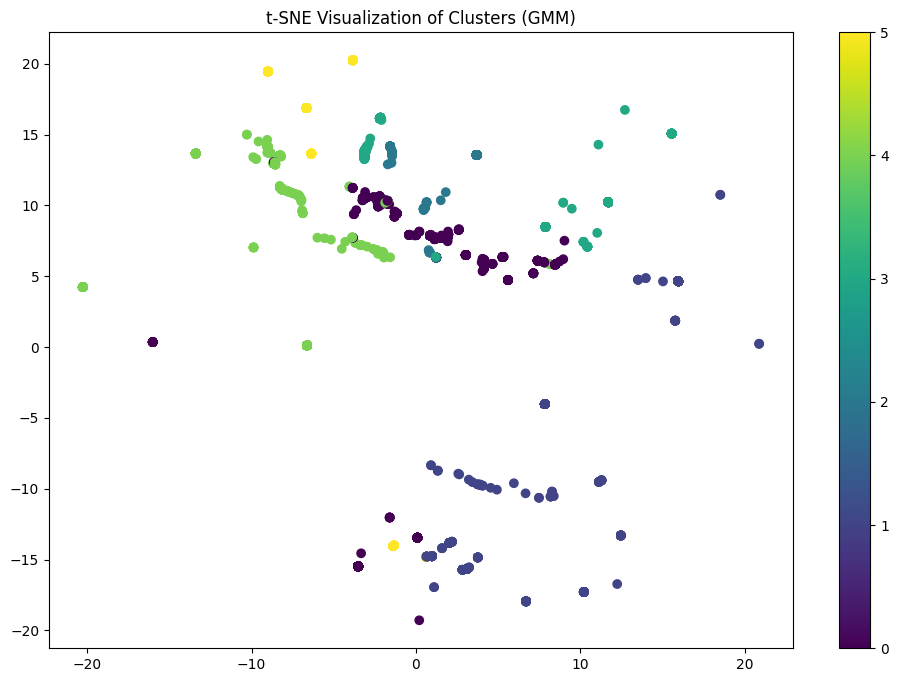

In [ ]:
## t-SNE - GMM

# PCA for dimensionality reduction
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=25, learning_rate=10, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# GMM with best parameters
gmm = GaussianMixture(**best_params_gmm, random_state=42)
gmm.fit(X)
gmm_labels = gmm.predict(X)

# Plotting GMM clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=gmm_labels, cmap='viridis', label='GMM')
plt.title('t-SNE Visualization of Clusters (GMM)')
plt.colorbar()
plt.savefig('/content/drive/My Drive/TSNE_GMM.png')
plt.show()

**4. Cluster analysis. Analyze the characteristics of each cluster. This might involve examining the most frequent words in each cluster (try word cloud). Try to understand which are the mostrepresentative.**


 **5.Do clusters reflect intent division, i.e., are the clusters homogeneous in terms of intents? How are intents divided into the clusters?**

In [6]:
## Word Cloud - GMM


X_tfidf = np.array(data['tf_idf'].tolist())


optimal_clusters = 6
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm.fit(X_tfidf)
cluster_assignments = gmm.predict(X_tfidf)
data['cluster'] = cluster_assignments


In [7]:
text_data = data['full_session'].tolist()
cluster_data = pd.DataFrame({'full_session': text_data, 'cluster': cluster_assignments})

# word frequencies function
def get_word_frequencies(texts):
    word_counter = Counter()
    for text in texts:
        words = text.split()
        word_counter.update(words)
    return word_counter

# word frequencies for each cluster
cluster_word_frequencies = {}
for cluster_id in range(optimal_clusters):
    cluster_texts = cluster_data[cluster_data['cluster'] == cluster_id]['full_session']
    cluster_word_frequencies[cluster_id] = get_word_frequencies(cluster_texts)

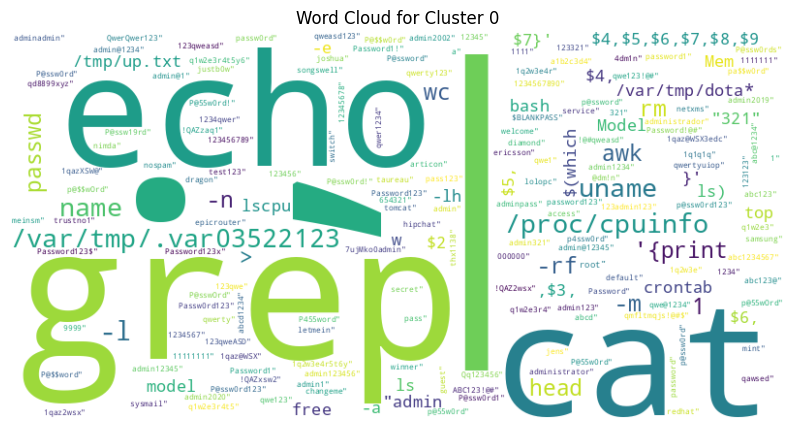

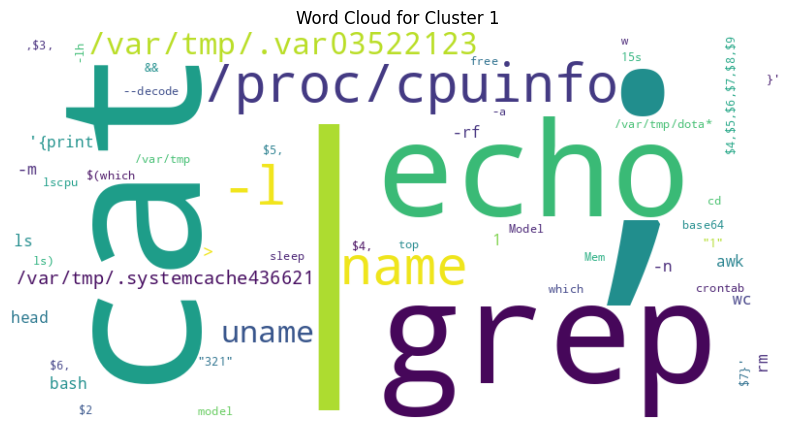

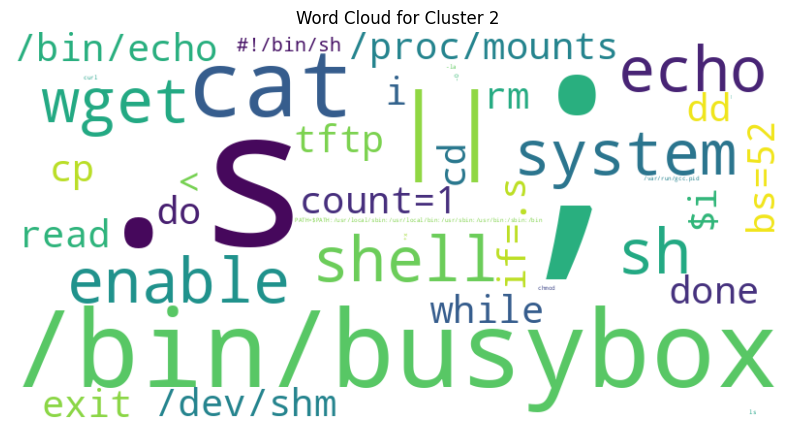

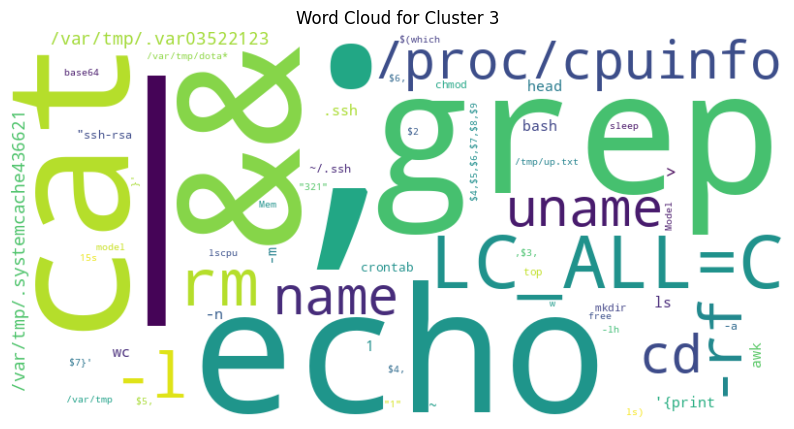

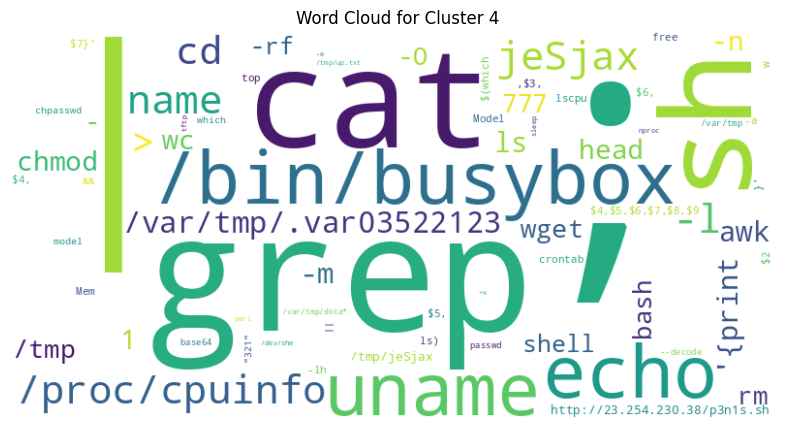

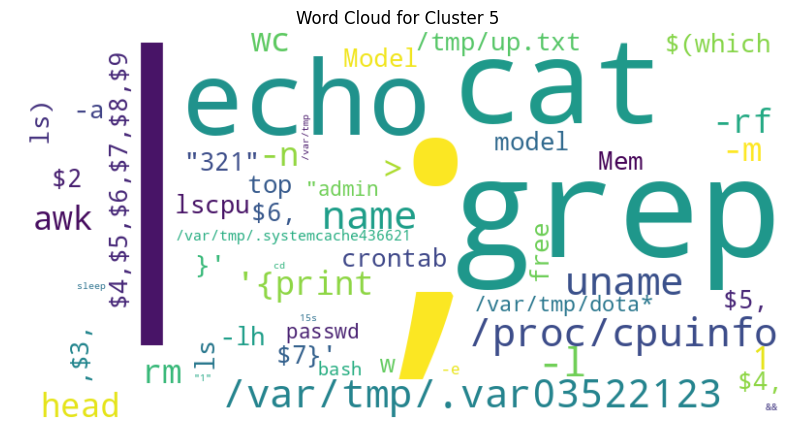

In [8]:
#word cloud from word frequencies function
def plot_word_cloud(word_frequencies, cluster_id):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.axis('off')
    output_path = f'/content/drive/My Drive/ML_project/wordcloud_GMM_cluster_{cluster_id}.png'
    wordcloud.to_file(output_path)
    plt.show()


for cluster_id, word_frequencies in cluster_word_frequencies.items():
    plot_word_cloud(word_frequencies, cluster_id)


**6. Find clusters of similar attacks, study their sessions and try to associate with them specific categories of attacks (more fine grained than the ones of MITRE ATT&CK Tactics).**




In [49]:
def fit_tfidf_gmm(data, num_clusters=6):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['full_session'])

    gmm = GaussianMixture(n_components=num_clusters, random_state=42)
    gmm.fit(tfidf_matrix)

    return tfidf_vectorizer, gmm, tfidf_matrix
def analyze_clusters(data, gmm, num_clusters_to_analyze=3):

    cluster_to_attack_categories = {
        0: ['Discovery', 'Execution', 'Impact'],
        1: ['Discovery', 'Defense Evasion', 'Impact'],
        2: ['Persistence', 'Privilege Escalation', 'Lateral Movement'],
        3: ['Discovery', 'Execution', 'Credential Access']
    }

    cluster_sessions = defaultdict(list)

    for cluster_id in range(num_clusters_to_analyze):
        cluster_data = data[data['cluster'] == cluster_id]
        sample_sessions = cluster_data['full_session'].sample(min(5, len(cluster_data)))
        cluster_sessions[cluster_id] = list(sample_sessions)

    for cluster_id, sessions in cluster_sessions.items():
        print(f"Cluster {cluster_id} - Sample Sessions:")
        for session in sessions:
            print(session)
            print("-" * 80)

        if cluster_id in cluster_to_attack_categories:
            print(f"Associated Attack Categories: {', '.join(cluster_to_attack_categories[cluster_id])}")
        else:
            print("No specific attack categories associated yet.")






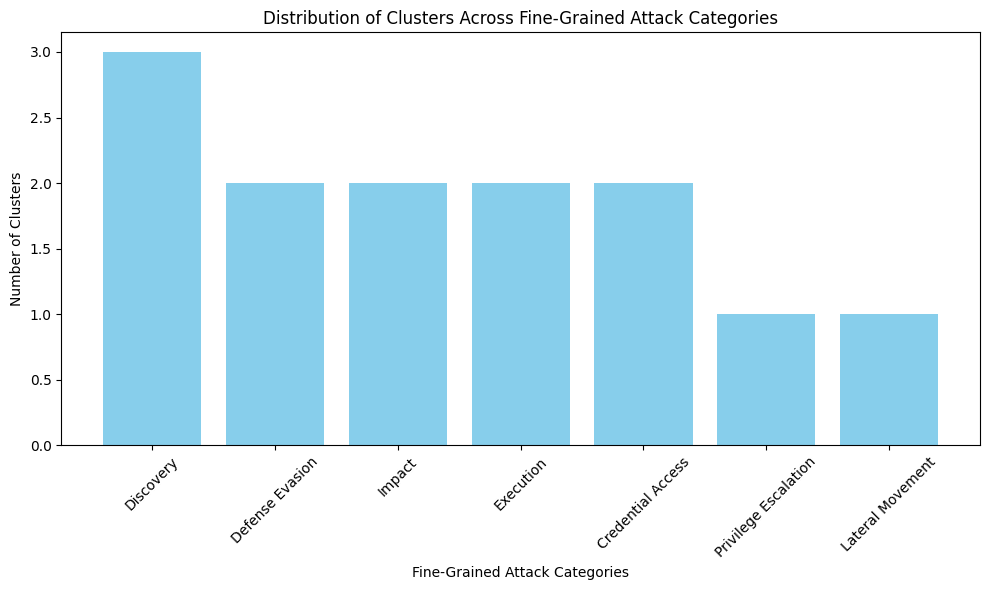

In [45]:
#occurrences of each fine-grained attack category across clusters
category_counts = {}
for categories in cluster_to_attack_categories.values():
    for category in categories:
        if category in category_counts:
            category_counts[category] += 1
        else:
            category_counts[category] = 1
#distribution of fine-grained attack categories
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.xlabel('Fine-Grained Attack Categories')
plt.ylabel('Number of Clusters')
plt.title('Distribution of Clusters Across Fine-Grained Attack Categories')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()